In [4]:
!pip install langchain langchain_core langchain_community langchain_openai langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 kB 4.8 MB/s eta 0:00:00


In [5]:
import operator
from typing import Annotated, TypedDict
from langchain_core.pydantic_v1 import BaseModel
from langchain_openai import ChatOpenAI
from langgraph.constants import Send
from langgraph.graph import END, StateGraph, START

In [6]:
from google.colab import userdata
import os

In [7]:
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

In [8]:
model = ChatOpenAI(model="gpt-4o-mini")

In [9]:
# Define the prompts
step1_prompt = """Step 1: I have a problem related to {input}.
Could you brainstorm three distinct solutions?
Please consider a variety of factors such as {perfect_factors}"""

step2_prompt = """Step 2: For each of the three proposed solutions, evaluate their potential.
Consider their pros and cons, initial effort needed, implementation difficulty, potential challenges,
and the expected outcomes. Assign a probability of success and a confidence level
to each option based on these factors.

Solutions:
{solutions}"""

step3_prompt = """Step 3: For each solution, deepen the thought process.
Generate potential scenarios, strategies for implementation, any necessary partnerships or resources,
and how potential obstacles might be overcome. Also, consider any potential unexpected outcomes
and how they might be handled.

Evaluation:
{review}"""

step4_prompt = """Step 4: Based on the evaluations and scenarios,
rank the solutions in order of promise. Provide a justification for each ranking
and offer any final thoughts or considerations for each solution.

Detailed analysis:
{deepen_thought_process}"""

In [10]:
# Define the output structures
class Solutions(BaseModel):
    solutions: list[str]

class Review(BaseModel):
    review: str

class DeepThought(BaseModel):
    deep_thought: str

class RankedSolutions(BaseModel):
    ranked_solutions: str

# Define the overall state
class OverallState(TypedDict):
    input: str
    perfect_factors: str
    solutions: Annotated[list[str], operator.add]
    reviews: Annotated[list[str], operator.add]
    deep_thoughts: Annotated[list[str], operator.add]
    ranked_solutions: str

# Define the state for individual solution processing
class SolutionState(TypedDict):
    solution: str

In [12]:
# Graph components
def generate_solutions(state: OverallState):
    prompt = step1_prompt.format(input=state["input"], perfect_factors=state["perfect_factors"])
    response = model.with_structured_output(Solutions).invoke(prompt)
    return {"solutions": response.solutions}

def evaluate_solution(state: SolutionState):
    prompt = step2_prompt.format(solutions=state["solution"])
    response = model.with_structured_output(Review).invoke(prompt)
    return {"reviews": [response.review]}

def deepen_thought(state: SolutionState):
    prompt = step3_prompt.format(review=state["solution"])
    response = model.with_structured_output(DeepThought).invoke(prompt)
    return {"deep_thoughts": [response.deep_thought]}

def rank_solutions(state: OverallState):
    deep_thoughts = "\n\n".join(state["deep_thoughts"])
    prompt = step4_prompt.format(deepen_thought_process=deep_thoughts)
    response = model.with_structured_output(RankedSolutions).invoke(prompt)
    return {"ranked_solutions": response.ranked_solutions}

# Define the mapping logic
def continue_to_evaluation(state: OverallState):
    return [Send("evaluate_solution", {"solution": s}) for s in state["solutions"]]

def continue_to_deep_thought(state: OverallState):
    return [Send("deepen_thought", {"solution": r}) for r in state["reviews"]]

In [13]:
# Construct the graph
graph = StateGraph(OverallState)

graph.add_node("generate_solutions", generate_solutions)
graph.add_node("evaluate_solution", evaluate_solution)
graph.add_node("deepen_thought", deepen_thought)
graph.add_node("rank_solutions", rank_solutions)

graph.add_edge(START, "generate_solutions")
graph.add_conditional_edges("generate_solutions", continue_to_evaluation, ["evaluate_solution"])
graph.add_conditional_edges("evaluate_solution", continue_to_deep_thought, ["deepen_thought"])
graph.add_edge("deepen_thought", "rank_solutions")
graph.add_edge("rank_solutions", END)

In [14]:
app = graph.compile()

In [15]:
# Call the graph
for s in app.stream({
    "input": "improving public transportation in a growing city",
    "perfect_factors": "cost, efficiency, environmental impact, and user experience"
}):
    print(s)

{'generate_solutions': {'solutions': ['Implement a Bus Rapid Transit (BRT) system that features dedicated bus lanes, priority signaling, and efficient transfer stations. This solution is cost-effective and can be deployed relatively quickly compared to rail systems, improving overall public transport efficiency while reducing emissions by promoting bus usage over individual car travel.', 'Introduce a bike-sharing program integrated with public transportation, allowing users to easily transition between bikes and buses or trains. This promotes a healthier lifestyle, reduces congestion, and lowers environmental impact, while also enhancing user experience by providing more flexible commuting options.', 'Expand the existing subway or light rail system with new lines and stations in underserved areas, coupled with modernized ticketing systems (like mobile apps and contactless payments). While this requires significant investment, it can greatly improve accessibility, reduce travel times, a

In [18]:
from pprint import pprint

In [19]:
pprint(s)

{'rank_solutions': {'ranked_solutions': '1. Bus Rapid Transit (BRT) System\n'
                                        '   - **Justification**: BRT systems '
                                        'are flexible, cost-effective, and can '
                                        'be implemented quickly compared to '
                                        'rail systems. They have shown '
                                        'significant success in reducing '
                                        'congestion and improving air quality '
                                        'in urban areas. The phased '
                                        'implementation strategy allows for '
                                        'adjustments based on community '
                                        'feedback, making it a promising '
                                        'solution for urban transport.\n'
                                        '   - **Final Thoughts**: Strong '
          

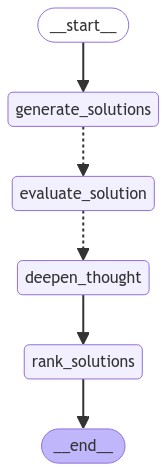

In [16]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())